In [384]:
import numpy as np

import cv2
import os
from math import ceil
from matplotlib import pyplot as plt
from copy import deepcopy
from Levenshtein import distance as levenshtein_distance
import time

# # For some reason all my files are "corrupted" and it won't work without this magic line :)
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [385]:
SCRIPT_PATH = os.getcwd()
TEXTS_DIRECTORY = os.path.join(SCRIPT_PATH, "texts")
CHARACTERS_DIRECTORY = os.path.join(SCRIPT_PATH, "fonts/alphabets")
ALPHABETS_DIRECTORY = os.path.join(SCRIPT_PATH, "alpha")

GREEN = (0, 255, 0)
BLACK = (0, 0, 0)
MARGIN = 20

ALPHABET = [str(i) for i in range(10)] + [chr(i) for i in range(ord("a"), ord("z") + 1)] + [".", ",", "?", "!", "(", ")", " "]

In [386]:
def add_margins(image, margin) :
    h, w = image.shape[:2]
    new_image = np.full((h + 2 * margin, w + 2 * margin, 3), 255, dtype=np.uint8)
    new_image[margin:margin+h, margin:margin+w] = image
    return new_image

In [387]:
def plot_image(image, titl = "", colormap = "gray") :
    plt.figure(figsize=(10, 10))
    plt.plot()
    plt.imshow(image, cmap = colormap)
    plt.title(titl)
    plt.axis('off')
    plt.show()

In [388]:
def simmilarity(a, b) :
    lev_dist = levenshtein_distance(a, b)

    max_len = max(len(a), len(b))

    return 1 - (lev_dist / max_len)

In [389]:
def invert_colors(image) :
    return cv2.bitwise_not(image)

In [390]:
def to_grayscale(image):
    if len(image.shape) == 2:
        return image  # Image is already in grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.bitwise_not(grayscale)

def from_grayscale(image) :
    
    image_array = np.asarray(cv2.bitwise_not(image))
    return np.array([[(val, val, val) for val in row] for row in image_array])

In [391]:
def initialize_characters(font_name) :
    alphabet_directory = os.path.join(CHARACTERS_DIRECTORY, font_name + "_alphabet")
    filenames = os.listdir(alphabet_directory)
    filenames.sort(key = lambda x : ord(x.split(".")[0]))
    characters = {}
    for name in filenames :
        text = name.split(".")[0]
        char = text
        if text == "A" : text = "."
        elif text == "B" : text = ","
        elif text == "C" : text = "?"
        elif text == "D" : text = "!"
        elif text == "E" : text = "("
        elif text == "F" : text = ")"
        elif text == "Z" : text = " "
        characters[text] = to_grayscale(cv2.imread(os.path.join(alphabet_directory, char + ".png")))
        
    return characters
        

In [392]:
def find_data(filenumber) :
    
    filename = None
    check_name = None
    font_name = None

    filenumber_str = str(filenumber)

    for file in os.listdir(TEXTS_DIRECTORY) :
        filetable = file.split("_")
        if filetable[0] == filenumber_str :
            font_name = filetable[2]
            if filetable[1] == "image" :
                filename = file
                if check_name is not None : break
            elif filetable[1] == "text" :
                check_name = file
                if filename is not None : break
    
    
    with open(os.path.join(TEXTS_DIRECTORY, check_name), 'r') as f:
        text_content = f.read()
                
    return filename, text_content, font_name


In [393]:
def new_line(col_num, i) :
    val = i % col_num
    if val == 0 : return i
    row_num = (i - val) // col_num
    i = (row_num + 1) * col_num
    return i

def plot_images(characters, items_in_row=10) :
    fig = plt.figure(figsize=(10, 7))
    rows_num, columns_num = ceil((len(characters) - 10 - 26) / items_in_row) + ceil(10/items_in_row) + ceil(26/items_in_row), items_in_row
    i = 0
    for character_key in characters :
        if character_key == "a" or character_key == "." : 
            i = new_line(columns_num, i)
        fig.add_subplot(rows_num, columns_num, i + 1)
        plt.imshow(invert_colors(add_margins(from_grayscale(characters[character_key]), 1)), cmap="gray")
        plt.axis("off")
        i += 1
    plt.show()

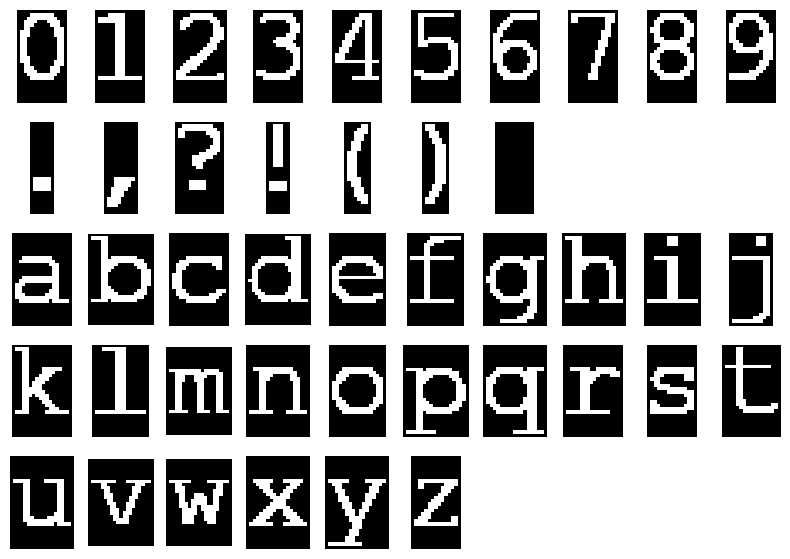

In [394]:
filename, check, font_name = find_data(0)
font_characters = initialize_characters(font_name)

plot_images(font_characters)

In [395]:
def black_pixels(image) :
    w, h = image.shape
    output = 0
    for x in range(w) :
        for y in range(h) :
            if image[x, y] == 255 : output += 1
    return output

In [396]:
def sort_characters(characters) :
    ordered_characters = list(characters)
    ordered_characters.sort(key = lambda x : black_pixels(characters[x]), reverse = True)
    return ordered_characters

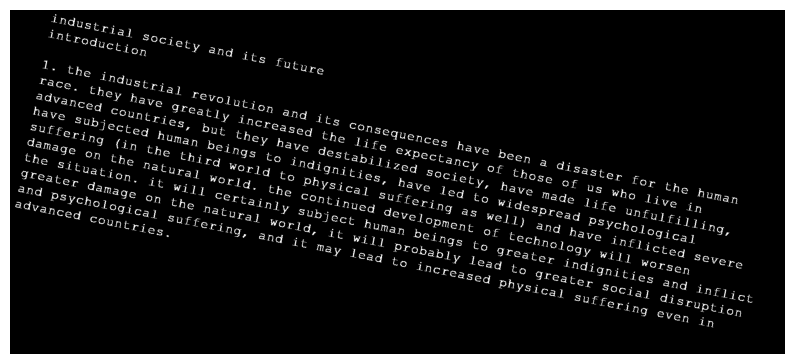

In [397]:
image = to_grayscale(cv2.imread(os.path.join(TEXTS_DIRECTORY, filename)))
plot_image(image)

In [398]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    cos = np.abs(np.cos(angle))
    sin = np.abs(np.sin(angle))
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    M = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1.0)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [399]:
def blacked(image_array):
    mask = np.any(image_array != [255, 255, 255], axis=-1)
    image_array[mask] = [0, 0, 0]
    return image_array

In [400]:
def cut_image(image) :
    image_array = np.array(image)

    non_white_cols = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=1)
    non_white_rows = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=0)

    minimal_row = float('inf')
    maximal_row = float('-inf')
    minimal_col = float('inf')
    maximal_col = float('-inf')

    for i in range(len(non_white_rows)) :
        val = non_white_rows[i]
        if val :
            minimal_row = min(minimal_row, i)
            maximal_row = max(maximal_row, i + 1)
    for i in range(len(non_white_cols)) :
        val = non_white_cols[i]
        if val :
            minimal_col = min(minimal_col, i)
            maximal_col = max(maximal_col, i + 1)
    
    x_range = maximal_row - minimal_row
    y_range = maximal_col - minimal_col
    
    new_image_array = np.zeros((y_range, x_range, 3))
    
    for x in range(x_range) :
        for y in range(y_range) :
            new_image_array[y,x] = image_array[minimal_col + y, minimal_row + x]
    
    return blacked(new_image_array)

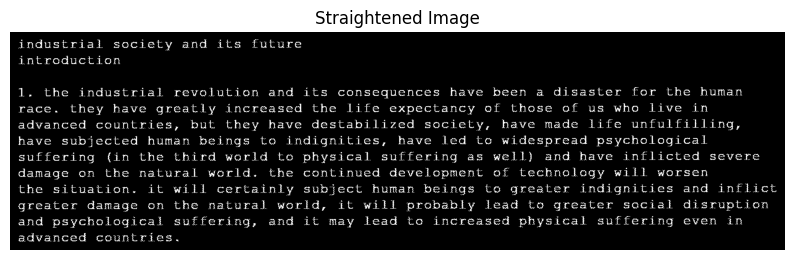

In [401]:
def denoise_image(image) :
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


def straighten_image(image) :
    global MARGIN
    image = from_grayscale(image)
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    angles = []
    if lines is not None :
        for _, theta in lines[:, 0] :
            angles.append(theta - np.pi / 2)
    
    if angles :
        mean_angle = np.mean(angles)
    else:
        mean_angle = 0
    
    new_image = cut_image(rotate_image(image, mean_angle))
    
    straightened_image = denoise_image(add_margins(new_image, MARGIN))
    
    return to_grayscale(straightened_image)

image = straighten_image(image)

plot_image(image, "Straightened Image")


In [402]:
def is_maximum(table, x, y, previously_found):
    h, w = table.shape
    val = table[x, y]
    stack = [(x, y)]
    local_max = (x, y)
    
    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in previously_found:
            continue
        previously_found.add((cx, cy))
        neighbors = [
            (i, j) for i in range(max(0, cx - 1), min(cx + 2, h))
                   for j in range(max(0, cy - 1), min(cy + 2, w))
                   if (i, j) not in previously_found
        ]
        for i, j in neighbors:
            if table[i, j] > val:
                return False, None
            if table[i, j] == val:
                stack.append((i, j))
                if (j, i) > (local_max[1], local_max[0]):
                    local_max = (i, j)
                    
    return True, local_max

In [403]:
def check_pattern(correlation, probability, mark, base_height, image, oneletter=False):
    p_h, p_w = mark
    max_points = np.argwhere(correlation > probability)
    
    sorted_indices = np.argsort(correlation[max_points[:, 0], max_points[:, 1]])[::-1]
    max_points = max_points[sorted_indices]
    
    new_points = set()
    
    for x, y in max_points:
        if (x, y) in new_points:
            continue
        boolean, point = is_maximum(correlation, x, y, set())
        if boolean:
            new_points.add(point)
    
    max_points = list(new_points)
    max_points.sort(key=lambda pt: correlation[pt], reverse=True)
    
    appearances = []
    
    for x, y in max_points:
        point = (y - p_w, x - p_h)
        if x <= base_height:
            appearances.append(point)
        image[max(0, point[1]):x + 1, max(0, point[0]):y + 1] = 0
        if oneletter:
            plot_image(image)
    
    return appearances, image

In [404]:
def find_corelation(image, pattern) :
    h, w = image.shape
    correlation = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(np.rot90(np.rot90(pattern)), s = (h, w))).real
    correlation /= np.abs(np.max(correlation))
    return correlation

In [405]:
def add_alphabet(image, font_name):
    font_name = font_name.replace("_", "")
    
    filename = os.path.join(ALPHABETS_DIRECTORY, f"image_{font_name}_.png")
    alphabet_image = to_grayscale(cv2.imread(filename))
    
    i_h, i_w = image.shape
    a_h, a_w = alphabet_image.shape
    
    new_h, new_w = i_h + a_h, max(i_w, a_w)
    new_image = np.full((new_h, new_w), 0, dtype=np.uint8)
    
    image_start = (0, (new_w - i_w) // 2)
    alphabet_start = (i_h, (new_w - a_w) // 2)
    
    new_image[image_start[0]:image_start[0] + i_h, image_start[1]:image_start[1] + i_w] = image
    new_image[alphabet_start[0]:alphabet_start[0] + a_h, alphabet_start[1]:alphabet_start[1] + a_w] = alphabet_image
    
    return new_image

In [406]:
def find_letters(image, font_characters, font_name, probability) :
    ordered_characters = sort_characters(font_characters)
    ordered_characters.pop()
    
    height = image.shape[0]
    
    image = add_alphabet(image, font_name)
    plot_image(image,"image with alphabet added")
    
    character_data = {}
    
    for character in ordered_characters :
        pattern = font_characters[str(character)]
        correlation = find_corelation(image, pattern)
        mark = pattern.shape
        character_data[character], image = check_pattern(correlation, probability, mark, height, image)
        # print("AFTER",character)
        # plot_image(image)
    
    return character_data

In [407]:
def find_letter(image, font_characters, font_name, character, probability) :
    height = image.shape[0]
    
    image = add_alphabet(image, font_name)
    plot_image(image,"image with alphabet added")
    
    character_data = {}
    
    pattern = font_characters[str(character)]
    correlation = find_corelation(image, pattern)
    mark = pattern.shape
    character_data[character], image = check_pattern(correlation, probability, mark, height, image, oneletter = True)
    print("AFTER",character)
    plot_image(image)
    
    return character_data

In [408]:
def create_points_of_intrest(character_data) :
    points_of_intrest = {}
    for key, values in character_data.items() :
        for point in values :
            points_of_intrest[point] = key
    return points_of_intrest

In [409]:
def distance(point_a, point_b) :
    return np.sqrt(((point_a[0] - point_b[0])**2) + ((point_a[1] - point_b[1])**2))

In [410]:
def find_first_point(points, line_height) :
    upmost_point = min(points, key = lambda x : (x[1], x[0]))
    
    def find(point) :
        nonlocal upmost_point, line_height
        if point[1] < upmost_point[1] + line_height :
            return point[0]
        return float('inf')

    leftmost_point = min(points, key = lambda x : find(x))
            
    return leftmost_point

In [411]:
def order_points(input_points, line_height) :
    points = deepcopy(input_points)
    
    lines = []
    while points :
        first_point = find_first_point(points, line_height)
        line = [first_point]
        for point in points :
            if point == first_point : continue
            if np.abs(point[1] - first_point[1]) < line_height :
                line.append(point)
        line.sort(key = lambda x : x[0])
        for point in line :
            points.remove(point)
        lines.append(line)
    
    return lines

In [412]:
def understand_points(character_data, font_characters, font_name) :
    space_width = int(round(font_characters[" "].shape[0] * (0.6)))
    space_height = 26 if font_name == "Arial" else 29
    points_of_intrest = create_points_of_intrest(character_data)
    points = list(points_of_intrest)
    lines = order_points(points, space_height)
    text = ""
    line_height = lines[1][0][1] - lines[0][0][1]
    
    for i, line in enumerate(lines) :
        prev = line[0]
        x = prev[0]
        y = prev[1]
        letter = points_of_intrest[prev]
        text += letter
        end_x = font_characters[letter].shape[1] + x
        for point in line :
            if point == prev : continue
            x = point[0]
            space_count = (x - end_x) // space_width
            for _ in range(space_count) :
                text += " "
            letter = points_of_intrest[point]
            text += letter
            end_x = font_characters[letter].shape[1] + x
            prev = point
        if i != len(lines) - 1 :
            next_y = lines[i + 1][0][1]
            for _ in range(round(((next_y - y) / line_height))) :
                text += "\n"
            
        else : break
    
    return text

In [413]:
def read(filenumber, letter = None) :
    filename, check, font_name = find_data(filenumber)
    
    image = to_grayscale(cv2.imread(os.path.join(TEXTS_DIRECTORY, filename)))
    plot_image(invert_colors(image), "Original image")
    
    plot_image(image, "Inverted image")
    
    probability = 0.97
    
    if filenumber < 2 :
        image = straighten_image(image)
        probability = 0.78
        if font_name == "Arial" : probability = 0.88
        plot_image(image, "Straightened image")
    font_characters = initialize_characters(font_name)
    
    plot_images(font_characters)
    
    
    if letter is None :
    
        character_data = find_letters(image, font_characters, font_name, probability)
        
        text = understand_points(character_data, font_characters, font_name)
        
        print(text)
        print("=====")
        print(check)
        print("=====")
        
        print(round(simmilarity(text, check)*100,2),"%")
    else :
        character_data = find_letter(image, font_characters, font_name, "e", probability)

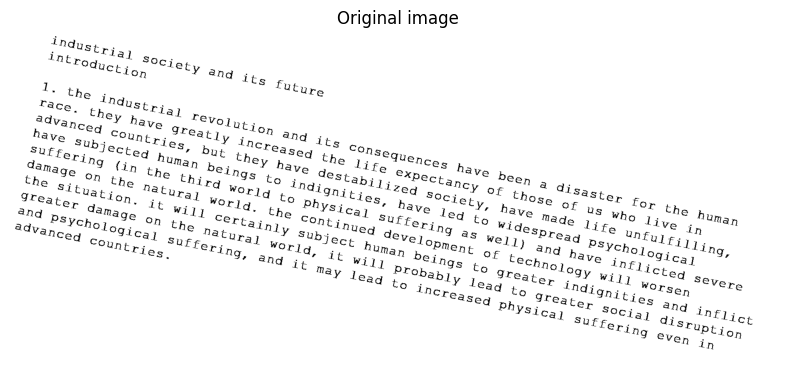

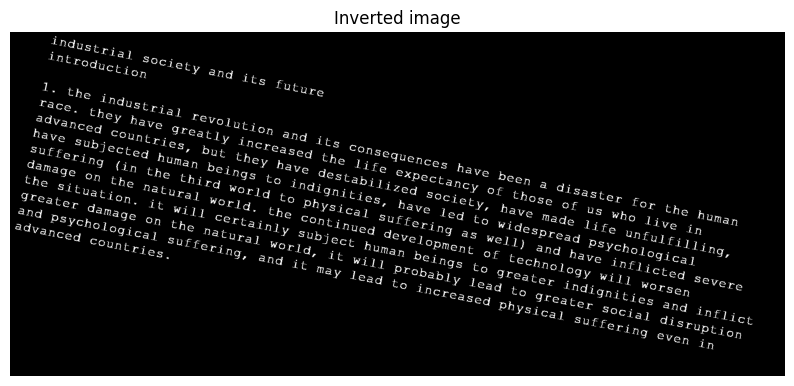

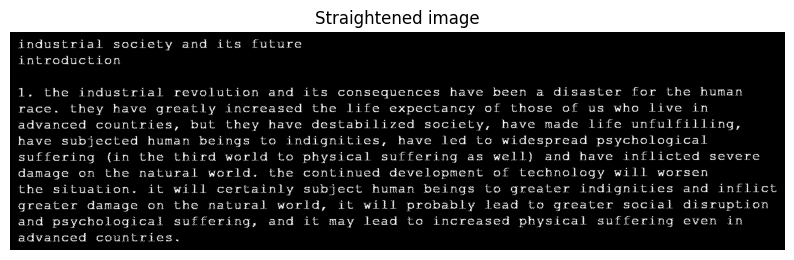

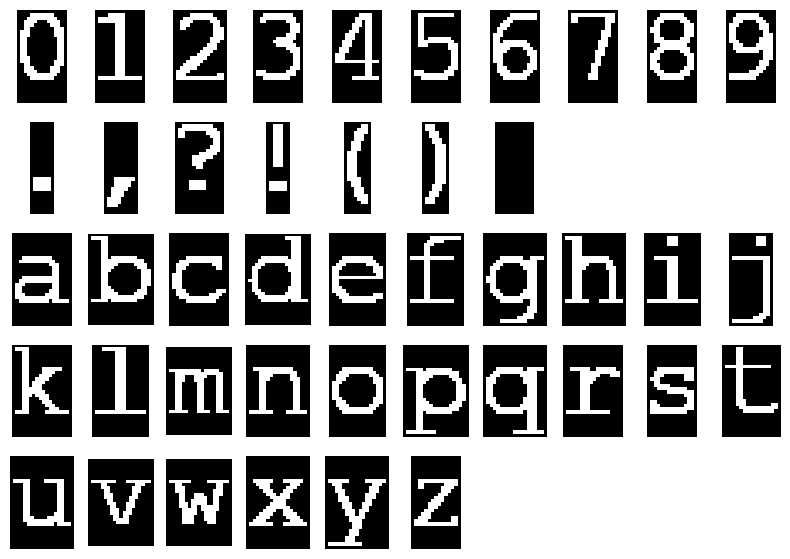

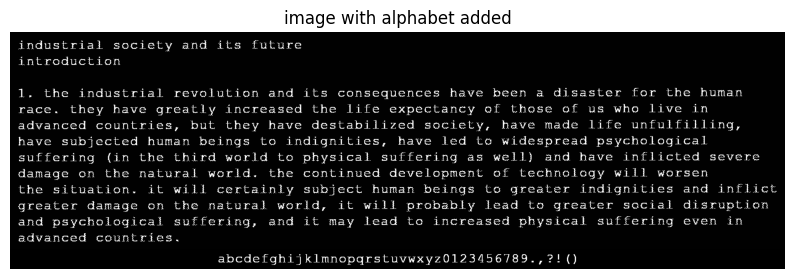

lndustrla1 soolety and l s future
lntreduotlon

1. tbe lndustrla1 revo1utlon and lts oensequenoes have been a dlsaster fer tbe buman
raoe. tbey have qreat1y lncreased tbe 1lle expectancy of those of us whe 1lve ln
advanoeq oountrles, but they have destapl1lzed soclety, bav  made 1lfe unfu1ll11lnq,
have supjeoteq buman belngs to lndlqnltlea, bave 1ed to wldespread psycbe1eqloa1
sullerlng (ln tbe thlrd wor1d to physloa1 suflerlng as we11)  and have lnf1loted severe
damaqe on the natural world. the oontlnueq qeve1opment o  techno1ogy wl11 woraen
the sltuatlon. lt wlll certaln1y subjeot buman belngs to grca er lndlgnltles and lnfllct
greater damage on the  atural world, lt wl11 probably lcad to greater soola1 dlsruptlon
and psyoho1ogioal su forlng, and lt may 1ead to lnoreascd physlca1 sufferlng even ln
advanoed oountrles.
=====
industrial society and its future
introduction

1. the industrial revolution and its consequences have been a disaster for the human
race. they have greatly increa

In [414]:
read(0)